In [1]:
!pip install rlberry==0.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=fe8a9b997d247e109c8a17a17bf8bcaf5d4755eace43a8317b2a641893459990
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import gym.spaces as spaces
from rlberry.agents import AgentWithSimplePolicy, UCBVIAgent
from rlberry.envs.benchmarks.grid_exploration.nroom import NRoom
from rlberry.exploration_tools.discrete_counter import DiscreteCounter
from rlberry.agents.dynprog import ValueIterationAgent

from rlberry.agents.dynprog.utils import (
    backward_induction_in_place,
    backward_induction_sd,
)
from rlberry.manager.evaluation import plot_writer_data

from rlberry.manager import AgentManager

import matplotlib.pyplot as plt
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 10,7
rcParams['mathtext.default'] = 'regular'
rcParams['font.size'] = 14

import logging
logger = logging.getLogger(__name__)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes
[INFO] NumExpr defaulting to 2 threads. 
[INFO] No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate' 
[INFO] Failed to load library ( 'libGLU.so.0' ): libGLU.so.0: cannot open shared object file: No such file or directory 


In [3]:
class PSRLAgent(AgentWithSimplePolicy):
    """
    PSRL algorithm from [1] with beta prior for the "Bernoullized" rewards
    (instead of Gaussian-gamma prior).

    Notes
    -----
    The recommended policy after all the episodes is computed without
    exploration bonuses.

    Parameters
    ----------
    env : gym.Env
        Environment with discrete states and actions.
    gamma : double, default: 1.0
        Discount factor in [0, 1]. If gamma is 1.0, the problem is set to
        be finite-horizon.
    horizon : int
        Horizon of the objective function. If None and gamma<1, set to
        1/(1-gamma).
    scale_prior_reward : double, delfault: 1.0
        scale of the Beta (uniform) prior,
        i.e prior is Beta(scale_prior_reward*(1,1))
    scale_prior_transition : double, default: 1/number of state
        scale of the (uniform) Dirichlet prior,
        i.e prior is Dirichlet(scale_prior_transition*(1,...,1))
    bernoullized_reward: bool, default: True
        If true the rewards are Bernoullized
    reward_free : bool, default: False
        If true, ignores rewards and uses only 1/n bonuses.
    stage_dependent : bool, default: False
        If true, assume that transitions and rewards can change with the stage h.

    References
    ----------
    .. [1] Osband et al., 2013
        (More) Efficient Reinforcement Learning via Posterior Sampling
        https://arxiv.org/abs/1306.0940

    """

    name = "PSRL"

    def __init__(
        self,
        env,
        gamma=1.0,
        horizon=100,
        scale_prior_reward=1,
        scale_prior_transition=None,
        bernoullized_reward=True,
        reward_free=False,
        stage_dependent=False,
        **kwargs
    ):
        # init base class
        AgentWithSimplePolicy.__init__(self, env, **kwargs)

        self.gamma = gamma
        self.horizon = horizon
        self.scale_prior_reward = scale_prior_reward
        self.scale_prior_transition = scale_prior_transition
        if scale_prior_transition is None:
            self.scale_prior_transition = 1.0 / self.env.observation_space.n
        self.bernoullized_reward = bernoullized_reward
        self.reward_free = reward_free
        self.stage_dependent = stage_dependent

        # check environment
        assert isinstance(self.env.observation_space, spaces.Discrete)
        assert isinstance(self.env.action_space, spaces.Discrete)

        # other checks
        assert gamma >= 0 and gamma <= 1.0
        if self.horizon is None:
            assert gamma < 1.0, "If no horizon is given, gamma must be smaller than 1."
            self.horizon = int(np.ceil(1.0 / (1.0 - gamma)))

        # maximum value
        r_range = self.env.reward_range[1] - self.env.reward_range[0]
        if r_range == np.inf or r_range == 0.0:
            logger.warning(
                "{}: Reward range is  zero or infinity. ".format(self.name)
                + "Setting it to 1."
            )
            r_range = 1.0

        self.v_max = np.zeros(self.horizon)
        self.v_max[-1] = r_range
        for hh in reversed(range(self.horizon - 1)):
            self.v_max[hh] = r_range + self.gamma * self.v_max[hh + 1]

        # initialize
        self.reset()

    def reset(self, **kwargs):
        H = self.horizon
        S = self.env.observation_space.n
        A = self.env.action_space.n

        if self.stage_dependent:
            shape_hsa = (H, S, A)
            shape_hsas = (H, S, A, S)
        else:
            shape_hsa = (S, A)
            shape_hsas = (S, A, S)

        # Prior transitions
        self.N_sas = self.scale_prior_transition * np.ones(shape_hsas)

        # Prior rewards
        self.M_sa = self.scale_prior_reward * np.ones(shape_hsa + (2,))

        # Value functions
        self.V = np.zeros((H, S))
        self.Q = np.zeros((H, S, A))
        # for rec. policy
        self.V_policy = np.zeros((H, S))
        self.Q_policy = np.zeros((H, S, A))

        # ep counter
        self.episode = 0

        # useful object to compute total number of visited states & entropy of visited states
        self.counter = DiscreteCounter(
            self.env.observation_space, self.env.action_space
        )

    def policy(self, observation):
        state = observation
        assert self.Q_policy is not None
        return self.Q_policy[0, state, :].argmax()


    def _get_action(self, state, hh=0):
        """Sampling policy."""
        assert self.Q is not None
        return self.Q[hh, state, :].argmax()

    def _update(self, state, action, next_state, reward, hh):
        bern_reward = reward
        if self.bernoullized_reward:
            bern_reward = self.rng.binomial(1, reward)
        # update posterior
        if self.stage_dependent:
            self.M_sa[hh, state, action, 0] += bern_reward
            self.M_sa[hh, state, action, 1] += 1 - bern_reward
            self.N_sas[hh, state, action, next_state] += 1
        else:
            self.M_sa[state, action, 0] += bern_reward
            self.M_sa[state, action, 1] += 1 - bern_reward
            self.N_sas[state, action, next_state] += 1

    def _run_episode(self):
        # sample reward and transitions from posterior

        self.R_sample = self.rng.beta(self.M_sa[..., 0], self.M_sa[..., 1])
        self.P_sample = self.rng.gamma(self.N_sas)
        self.P_sample = self.P_sample / self.P_sample.sum(-1, keepdims=True)

        # run backward induction
        if self.stage_dependent:
            backward_induction_sd(
                self.Q, self.V, self.R_sample, self.P_sample, self.gamma, self.v_max[0]
            )
        else:
            backward_induction_in_place(
                self.Q,
                self.V,
                self.R_sample,
                self.P_sample,
                self.horizon,
                self.gamma,
                self.v_max[0],
            )
        # interact for H steps
        episode_rewards = 0
        observation = self.env.reset()
        for hh in range(self.horizon):
            action = self._get_action(observation, hh)
            next_observation, reward, done, _ = self.env.step(
                action
            )

            episode_rewards += reward  # used for logging only

            self.counter.update(observation, action)

            if self.reward_free:
                reward = 0.0  # set to zero before update if reward_free

            self._update(observation, action, next_observation, reward, hh)

            observation = next_observation
            if done:
                break

        # update info
        self.episode += 1

        # writer
        if self.writer is not None:
            self.writer.add_scalar("episode_rewards", episode_rewards, self.episode)
            self.writer.add_scalar(
                "n_visited_states", self.counter.get_n_visited_states(), self.episode
            )

        # return sum of rewards collected in the episode
        return episode_rewards

    def fit(self, budget: int, **kwargs):
        """
        Train the agent using the provided environment.

        Parameters
        ----------
        budget: int
            number of episodes. Each episode runs for self.horizon unless it
            enconters a terminal state in which case it stops early.
        """
        del kwargs
        n_episodes_to_run = budget
        count = 0
        while count < n_episodes_to_run:
            self._run_episode()
            count += 1

        # compute Q function for the recommended policy

        R_hat = self.M_sa[..., 0] / (self.M_sa[..., 0] + self.M_sa[..., 1])
        P_hat = self.N_sas / self.N_sas.sum(-1, keepdims=True)

        if self.stage_dependent:
            backward_induction_sd(
                self.Q_policy, self.V_policy, R_hat, P_hat, self.gamma, self.v_max[0]
            )
        else:
            backward_induction_in_place(
                self.Q_policy,
                self.V_policy,
                R_hat,
                P_hat,
                self.horizon,
                self.gamma,
                self.v_max[0],
            )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
from rlberry.envs.finite import GridWorld

def constructor(nrows, ncols, success_probability):
    env = GridWorld(nrows=nrows, ncols=ncols, walls=(), success_probability=success_probability)
    return env

# def constructor(nrooms, room_size, success_probability):
#     env = NRoom( nrooms=nrooms,
#                  room_size=room_size,
#                  success_probability=success_probability)
#     env.terminal_states = ()
#     return env

env = constructor
# env_kwargs = {"nrooms": 5,
#               "room_size": 5,
#               "success_probability": 0.8}
env_kwargs = {"nrows": 5,
              "ncols": 5,
              "success_probability": 0.8}

psrl_init_args = {"horizon": 50,
                  "gamma": 1.0,
                  "stage_dependent": False}

ucbvi_init_args = {"horizon": 50,
                   "gamma": 1.0,
                   "bonus_scale_factor": 1.0,
                   "stage_dependent": False,
                   "real_time_dp": False}

fit_args = {"fit_budget": 2500} #Can be more but in colab is time consuming

psrl_manager = AgentManager(PSRLAgent,
                            seed=42,
                            train_env=(env, env_kwargs),
                            eval_env=(env, env_kwargs),
                            init_kwargs=psrl_init_args,
                            fit_kwargs=fit_args)

ucbvi_manager = AgentManager(UCBVIAgent,
                             seed=42,
                             train_env=(env, env_kwargs),
                             eval_env=(env, env_kwargs),
                             init_kwargs=ucbvi_init_args,
                             fit_kwargs=fit_args)

managers = [psrl_manager,
            ucbvi_manager]

In [5]:
for manager in managers:
    manager.fit()

[INFO] Running AgentManager fit() for PSRL...  
[INFO] [PSRL[worker: 3]] | max_global_step = 70 | episode_rewards = 40.0 | dw_time_elapsed = 3.001122085999995 | n_visited_states = 25 |  
[INFO] [PSRL[worker: 0]] | max_global_step = 74 | episode_rewards = 34.0 | dw_time_elapsed = 3.0316728440000134 | n_visited_states = 25 |  
[INFO] [PSRL[worker: 1]] | max_global_step = 73 | episode_rewards = 30.0 | dw_time_elapsed = 3.0181342360000087 | n_visited_states = 25 |  
[INFO] [PSRL[worker: 2]] | max_global_step = 77 | episode_rewards = 42.0 | dw_time_elapsed = 3.0171743840000005 | n_visited_states = 25 |  
[INFO] [PSRL[worker: 3]] | max_global_step = 204 | episode_rewards = 36.0 | dw_time_elapsed = 6.022878004000006 | n_visited_states = 25 |  
[INFO] [PSRL[worker: 0]] | max_global_step = 202 | episode_rewards = 36.0 | dw_time_elapsed = 6.046202172000008 | n_visited_states = 25 |  
[INFO] [PSRL[worker: 1]] | max_global_step = 206 | episode_rewards = 0.0 | dw_time_elapsed = 6.020125598000007 | 

In [6]:
env = managers[0].train_env
horizon = manager.get_agent_instances()[0].horizon
vi_agent = ValueIterationAgent(env, gamma=1.0, horizon=horizon)
vi_agent.fit(budget=2000)
v_star = vi_agent.V[0,vi_agent.env.reset()]

v_star

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


39.45822130313782

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


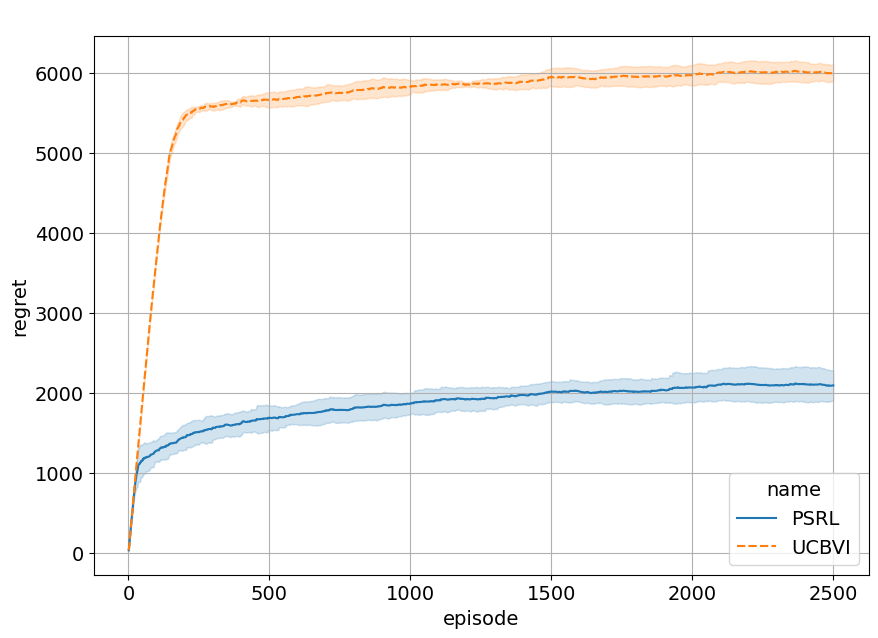

In [7]:
def compute_regret(episode_rewards):
    return np.cumsum(v_star - episode_rewards)

res = plot_writer_data(managers, tag="episode_rewards", show = False, preprocess_func=compute_regret, title=' ')
plt.ylabel('regret')
plt.xlabel('episode')
plt.grid()
plt.savefig("PSRLvsUCBVI.png")